In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
from sklearn.metrics import silhouette_score


In [ ]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
from sklearn.model_selection import train_test_split



In [ ]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [ ]:
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens.to(device))
    embeddings = output.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings


In [ ]:
df['bert_embedding'] = df['message'].apply(get_bert_embedding)


In [ ]:
X = np.vstack(df['bert_embedding'].to_numpy())

In [ ]:
X

array([[ 0.08564048, -0.5351515 ,  0.5795286 , ..., -0.0522707 ,
         0.29215226, -0.03900453],
       [ 0.07416045, -0.2920679 ,  0.28948653, ...,  0.15055181,
        -0.07654782,  0.05337835],
       [ 0.07410222, -0.06461929,  0.81856906, ..., -0.1393411 ,
         0.02458197,  0.22032973],
       ...,
       [ 0.16393188, -0.05190447,  0.34867454, ...,  0.07627543,
         0.05241312, -0.04477345],
       [ 0.10472482, -0.25824246,  0.10970839, ..., -0.22135712,
         0.10682324, -0.14448419],
       [-0.06863373, -0.34529015, -0.11418188, ...,  0.02042714,
         0.49969855,  0.20645097]], dtype=float32)

In [ ]:
len(X)

5572

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)

In [ ]:
reduced_embeddings

array([[-2.581745  ,  1.1839219 ],
       [-2.35955   ,  3.1294863 ],
       [-2.615154  , -2.338918  ],
       ...,
       [ 0.59772044,  0.5360609 ],
       [ 0.87354267, -0.9414787 ],
       [-0.52561885,  0.9281704 ]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    reduced_embeddings,
    df.label_num,
    test_size=0.2,
    random_state=42
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report


lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

pred=lr.predict(X_test)

accuracy=accuracy_score(y_test,pred)
report=classification_report(y_test,pred)

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_test, pred)

print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9641255605381166
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       965
           1       0.81      0.97      0.88       150

    accuracy                           0.96      1115
   macro avg       0.90      0.97      0.93      1115
weighted avg       0.97      0.96      0.97      1115

Confusion Matrix:
[[930  35]
 [  5 145]]


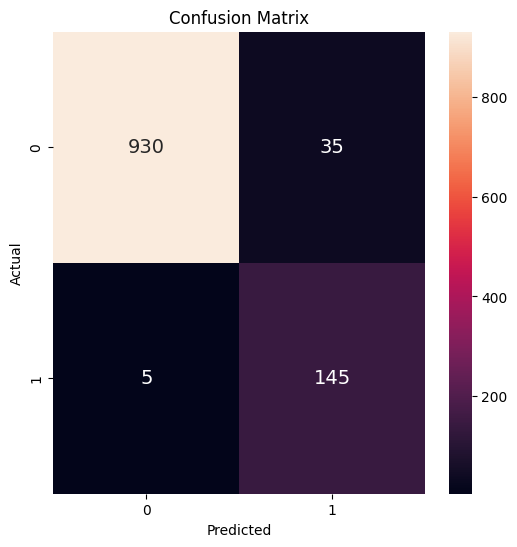

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True, annot_kws={"size": 14})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()